# Crop-type image library

Using example locations of crop types in different regions of Africa, create example images and NDVI timeseries to assist in the training and validation data collections

Image library is here: https://docs.google.com/document/d/1lLOYIM12_E09kC6l0ezUzBngYFTC7DDEIftAZzmvn2M/edit?usp=sharing

In [1]:
import geopandas as gpd
import datacube
import numpy as np
import sys
import xarray as xr
from datacube.utils import geometry
import matplotlib.pyplot as plt 
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb, map_shapefile
from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
dc = datacube.Datacube(app='image_lib')

## Analysis Parameters

In [3]:
shp_file= 'data/crop_type_library/western/Soyabean.geojson'
product = 's2_l2a'#'usgs_ls8c_level2_2'# 'ls8_usgs_sr_scene'
time_ndvi = ('2018-06', '2019-12')
time_rgb = ('2019')

## Open file and check extents

In [4]:
gdf = gpd.read_file(shp_file).to_crs('epsg:4326')

In [5]:
map_shapefile(gdf, attribute='Name', hover_col='Name')

Label(value='')

Map(center=[10.282540971241154, -0.16601135080000348], controls=(ZoomControl(options=['position', 'zoom_in_tex…

## Extract RGB and NDVI time-series

In [6]:
ndvi_dict = {}
rgb_dict = {}
for index, row in gdf.iterrows():
    name=gdf.iloc[[index]].Name.values[0]
    print(name)
    geom = geometry.Geometry(
            gdf.geometry.values[index].__geo_interface__, geometry.CRS(
                    'epsg:4326'))
    query_ndvi = {
        "geopolygon": geom,
        'time': time_ndvi,
        'measurements': ['red',
                         'nir'],
        'resolution': (-10, 10),
        'group_by': 'solar_day',
        'output_crs':'EPSG:6933'
    }

    # load cloud-masked fractional cover using load_ard
    with HiddenPrints():
        ds = load_ard(dc=dc,
                  **query_ndvi,
                  products=[product], 
                  min_gooddata=0.75
                 )
    
    with HiddenPrints():
        mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    ds = ds.where(mask)
    ds = calculate_indices(ds, 'NDVI', collection='c1')
    ds_index = ds.mean(['x','y'])
    ds_index = ds_index.interpolate_na(dim="time", method="linear")
    ds_index = ds_index.resample(time="1M").median()
    ndvi_dict[name] = ds_index
    
#     query_rgb = {
#         "geopolygon": geom,
#         'time': time_rgb,
#         'measurements': ['green',
#                          'blue',
#                          'red'],
#         'resolution': (-10, 10),
#         'group_by': 'solar_day',
#         'output_crs':'EPSG:6933'
#     }
    
#     # load cloud-masked fractional cover using load_ard
#     with HiddenPrints():
#         ds = load_ard(dc=dc,
#                   **query_rgb,
#                   products=[product],
#                   min_gooddata=1.0
#                  )
    
#     with HiddenPrints():
#         mask = xr_rasterize(gdf.iloc[[index]], ds)
    
#     ds = ds.where(mask)
    
#     rgb_dict[name]=ds

Soyabean1
Soyabean2
Soyabean
Soyabean


In [15]:
key = 'Soyabean1'

Text(0.5, 1.0, 'Soyabean s2_l2a')

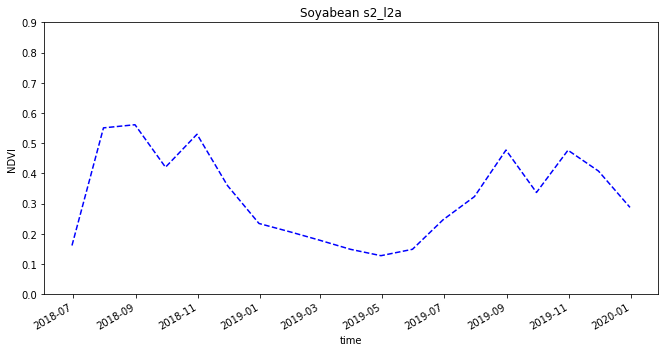

In [16]:
ndvi_dict[key].NDVI.plot.line('b--', figsize=(11,5))
plt.ylim(0,0.9)
plt.title(key[0:-1] +" "+ product)

In [17]:
# rgb(rgb_dict[key], index=list(range(0,len(rgb_dict[key].time))))